In [2]:
import SleepAnalysisDSP as sa
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pandas as pd
import seaborn as sns
import heartpy as hp

%config InlineBackend.figure_format = 'svg'
# read the csv file into a pandas dataframe
print("Reading Data from File...")
FILE = "Sensordata\RawData01122021.csv"
# name = "29112021_sensor_data"
data = pd.read_csv(FILE, names=["timestamp", "value"], delimiter=",")
print("Complete!")
# calculate smoothed dataset and backfill missing data from phaseshift
data["smoothed_ts"] = data["timestamp"].rolling(5, win_type="hanning").mean()
data["smoothed_v"] = data["value"].rolling(5, win_type="hanning").mean()
data["smoothed_ts"] = data["smoothed_ts"].bfill()
data["smoothed_v"] = data["smoothed_v"].bfill()
fs_sm = sa.get_sampling_freq(data["smoothed_ts"].to_numpy())
# filter (and upsample for HR) the smoothed datasets
#TODO separate the filter output and writing to dataframe. Slows down the program
print("Filtering Signal...")
l=0.05
h=int(fs_sm/2)
bp_filt = sa.filter_bp(l,h,data["smoothed_v"], fs_sm)
hr_filt = sa.filter_hr(data["smoothed_v"], fs_sm)
resampled_hr_filt = sa.resample(hr_filt, len(hr_filt) * 4)
rr_filt = sa.filter_rr(data["smoothed_v"], fs_sm)
resampled_rr_filt = sa.resample(rr_filt, len(rr_filt) * 4)
print("Filtering done!")
# # write to dataframe
# data["filtered_hr"] = hr_filt
# data["filtered_rr"] = rr_filt


# # # write file for evaluation
# # headings = {
# #     "hr_sensor": list(map(int, heart_rates)),
# #     "rr_sensor": list(map(int, resp_rates)),
# #     "ss_sensor": list(map(int, sp_values)),
# # }
# # df = pd.DataFrame(headings)
# # print(df)
# # df.to_csv("Sensordata/clean/" + name, encoding="utf-8", index=False)

# # Create the Plot
# print("Plotting...")

# plot_dash(
#     data["smoothed_v"].to_numpy(),
#     hr_filt,
#     rr_filt,
#     heart_rates,
#     hrv,
#     resp_rates,
#     movement,
#     data["smoothed_ts"].to_numpy(),
#     hr_timecodes,
#     rr_timecodes,
#     sp_values,
#     sp_stats,
# )


Reading Data from File...
Complete!
Filtering Signal...
Filtering done!


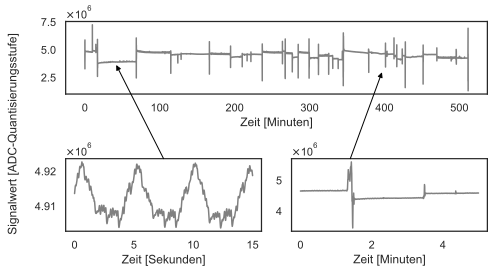

In [47]:
from matplotlib.patches import ConnectionPatch
l1,l2=11.5,400
wid,wid2=0.25,5
l1_raw,l2_raw=int(l1*60*fs_sm),int(l2*60*fs_sm)
wid_raw,wid2_raw=int(wid*60*fs_sm),int(wid2*60*fs_sm)
gridsize = (2, 2)
fig = plt.figure(figsize=(7, 4))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid(gridsize, (1, 0))
ax3 = plt.subplot2grid(gridsize, (1, 1))
sns.set_style("white")
first=data["smoothed_ts"][0]
data_raw_x=((data["smoothed_ts"]-first)/60_000_000).tolist()
data_raw_y=data["smoothed_v"].tolist()
ax1.ticklabel_format(style="sci", axis="y", useMathText=True)
ax2.ticklabel_format(style="sci", axis="y", useMathText=True)
ax3.ticklabel_format(style="sci", axis="y", useMathText=True)
ax1.plot(data_raw_x,data_raw_y, color="grey")
#ax1.annotate('', xy=(l1*3, 3.3e6), xytext=(l1+wid*200, -1e6), arrowprops=dict(facecolor='black', shrink=0.05))
#ax1.annotate('', xy=(l2, 3.3e6), xytext=(l2-wid*110, -1e6), arrowprops=dict(facecolor='black', shrink=0.05))
ax1.set_xlabel("Zeit [Minuten]")
ax2.plot(np.linspace(0, 15,1287),data_raw_y[l1_raw:l1_raw+wid_raw], color="grey")
ax2.set_xlabel("Zeit [Sekunden]")
ax3.plot(np.linspace(0, 5,25751),data_raw_y[l2_raw:l2_raw+wid2_raw], color="grey")
ax3.set_xlabel("Zeit [Minuten]")
fig.supylabel("Signalwert [ADC-Quantisierungsstufe]", fontsize=12)
con1 = ConnectionPatch(xyA=(0.5,1), coordsA=ax2.transAxes,xyB=(0.12,0.4), coordsB=ax1.transAxes,arrowstyle="-|>")
con1.set_color([0, 0, 0])
con1.set_linewidth(1)
con2 = ConnectionPatch(xyA=(0.3,1), coordsA=ax3.transAxes,xyB=(0.75,0.3), coordsB=ax1.transAxes,arrowstyle="-|>")
con2.set_color([0, 0, 0])
con2.set_linewidth(1)
fig.add_artist(con1)
fig.add_artist(con2)
plt.tight_layout()
plt.show()

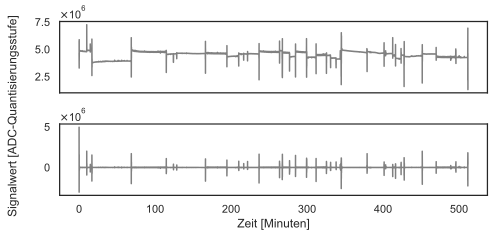

In [103]:
fig, ax = plt.subplots(2,1,sharex=True)
sns.set(rc={"figure.figsize": (7, 3.5)})
sns.set_style("white")
first=data["smoothed_ts"][0]
fig.supylabel("Signalwert [ADC-Quantisierungsstufe]", fontsize=12)
ax[0].ticklabel_format(style="sci", axis="y", useMathText=True)
ax[0].plot((data["smoothed_ts"]-first)/60_000_000,data["smoothed_v"], color="grey", label=f"Unverarbeitetes Signal, Samplingfrequenz: {fs_sm:.2f} Hz")
#ax[0].legend()
ax[1].ticklabel_format(style="sci", axis="y", useMathText=True)
ax[1].plot((data["smoothed_ts"]-first)/60_000_000,bp_filt, color="grey", label="Bandpass gefiltert (0.1 - 42.0 Hz)")
#ax[1].legend()
plt.xlabel("Zeit [Minuten]")
plt.tight_layout()
plt.show()

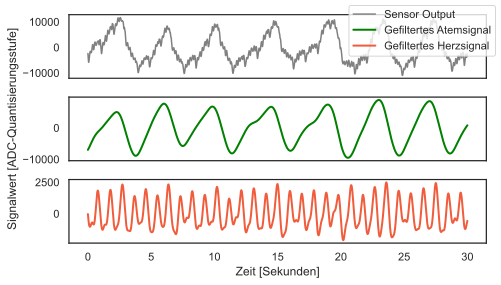

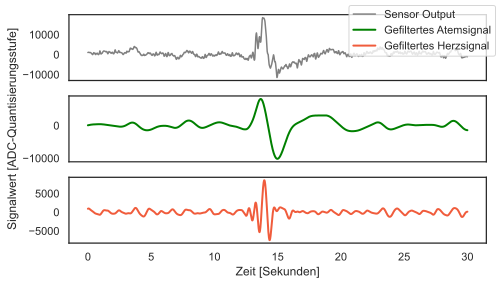

In [5]:
sns.set(rc={"figure.figsize": (7, 4)})
sns.set_style("white")
low_good = 28000
low_bad = 114000
offset1=70
offset2=70
fig, ax = plt.subplots(3,1,sharex=True)
ax[0].plot(np.linspace(0, 2575 / fs_sm, 2575),bp_filt[low_good:low_good+2575], color="grey", label="Sensor Output")
ax[1].set_ylabel("Signalwert [ADC-Quantisierungsstufe]")
ax[1].plot(np.linspace(0, 2575 / fs_sm, 2575),rr_filt[low_good+offset1:low_good+offset1+2575], color="green", linewidth=2, label="Gefiltertes Atemsignal")
ax[2].plot(np.linspace(0, 2575 / fs_sm, 2575),hr_filt[low_good+offset2:low_good+offset2+2575], color="#F05C3C", linewidth=2, label="Gefiltertes Herzsignal")
fig.legend()
plt.xlabel("Zeit [Sekunden]")
plt.tight_layout()
plt.show()
sns.set(rc={"figure.figsize": (7, 4)})
sns.set_style("white")
fig, ax = plt.subplots(3,1,sharex=True)
ax[0].plot(np.linspace(0, 2575 / fs_sm, 2575),bp_filt[low_bad:low_bad+2575], color="grey", label="Sensor Output")
ax[1].set_ylabel("Signalwert [ADC-Quantisierungsstufe]")
ax[1].plot(np.linspace(0, 2575 / fs_sm, 2575),rr_filt[low_bad+offset1:low_bad+offset1+2575], color="green", linewidth=2, label="Gefiltertes Atemsignal")
ax[2].plot(np.linspace(0, 2575 / fs_sm, 2575),hr_filt[low_bad+offset2:low_bad+offset2+2575], color="#F05C3C", linewidth=2, label="Gefiltertes Herzsignal")
fig.legend()
plt.xlabel("Zeit [Sekunden]")
plt.tight_layout()
plt.show()

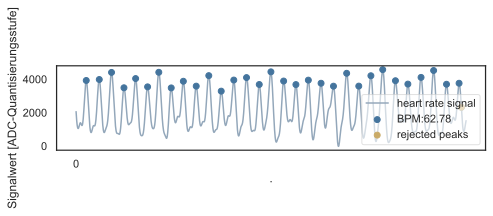

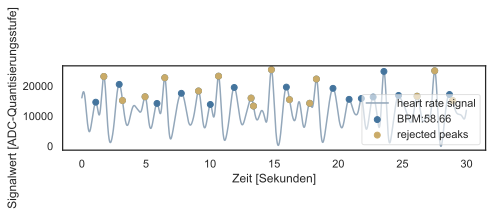

d:\Dokumente\Uni\Masterarbeit\Code\.venv\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Dokumente\Uni\Masterarbeit\Code\.venv\lib\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\Dokumente\Uni\Masterarbeit\Code\.venv\lib\site-packages\numpy\ma\core.py:5246: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
d:\Dokumente\Uni\Masterarbeit\Code\.venv\lib\site-packages\numpy\core\fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


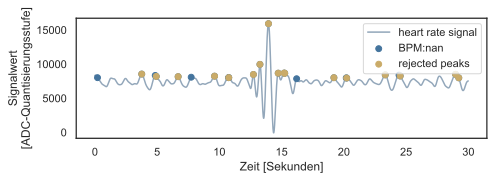

In [6]:
# HeartPy
wd,m =hp.process(hr_filt[low_good+offset2:low_good+offset2+2575], fs_sm)
hp.config.color_style = "corporate"
sns.set(rc={"figure.figsize": (7, 2)})
sns.set_style("white")
hp.plotter(wd,m,show=False, title=None)
plt.xticks([0])
plt.xlabel(".")
plt.ylabel("Signalwert [ADC-Quantisierungsstufe]")
plt.tight_layout()
plt.show()
move=1360000
wd,m =hp.process(hr_filt[low_good+move:low_good+move+2575], fs_sm)
sns.set(rc={"figure.figsize": (7, 2)})
sns.set_style("white")
hp.plotter(wd,m,show=False, title=None)
plt.xlabel("Zeit [Sekunden]")
plt.ylabel("Signalwert [ADC-Quantisierungsstufe]")
plt.tight_layout()
plt.show()
wd,m =hp.process(hr_filt[low_bad+offset2:low_bad+offset2+2575], fs_sm)
hp.config.color_style = "corporate"
sns.set(rc={"figure.figsize": (7, 2.5)})
sns.set_style("white")
hp.plotter(wd,m,show=False)
plt.title(None)
plt.legend(loc="upper right")
plt.xlabel("Zeit [Sekunden]")
plt.ylabel("Signalwert\n[ADC-Quantisierungsstufe]")
plt.tight_layout()
plt.show()

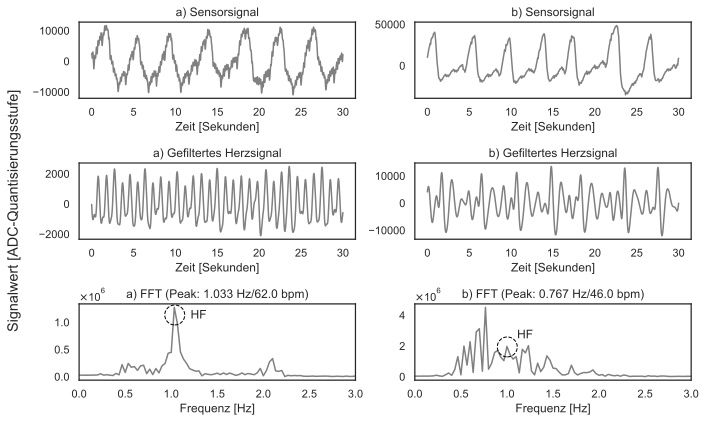

In [130]:
sns.set(rc={"figure.figsize": (10, 6)})
sns.set_style("white")
fig, ax = plt.subplots(3,2)
from scipy.fft import rfft, rfftfreq
N = len(hr_filt[low_good+offset2:low_good+offset2+2575])
yf = rfft(hr_filt[low_good+offset2:low_good+offset2+2575])
xf = rfftfreq(N, 1 / fs_sm)
hr = 60*xf[np.argmax((np.abs(yf)))]
ax[0,0].plot(np.linspace(0, 2575 / fs_sm, 2575),bp_filt[low_good+offset2:low_good+offset2+2575], color="grey")
ax[0,0].set_title("a) Sensorsignal")
ax[0,0].set_xlabel("Zeit [Sekunden]")
ax[1,0].plot(np.linspace(0, 2575 / fs_sm, 2575),hr_filt[low_good+offset2:low_good+offset2+2575], color="grey")
ax[1,0].set_title("a) Gefiltertes Herzsignal")
ax[1,0].set_xlabel("Zeit [Sekunden]")
ax[2,0].plot(xf, np.abs(yf), color="grey")
ax[2,0].ticklabel_format(style="sci", axis="y", useMathText=True)
ax[2,0].set_title(f"a) FFT (Peak: {xf[np.argmax((np.abs(yf)))]:.3f} Hz/{hr:.1f} bpm)")
ax[2,0].set_xlabel("Frequenz [Hz]")
ax[2,0].set_xlim(0,3)
move=1360000
N = len(hr_filt[low_good+move:low_good+move+2575])
yf = rfft(hr_filt[low_good+move:low_good+move+2575])
xf = rfftfreq(N, 1 / fs_sm)
hr = 60*xf[np.argmax((np.abs(yf)))]
ax[0,1].plot(np.linspace(0, 2575 / fs_sm, 2575),bp_filt[low_good+move:low_good+move+2575], color="grey")
ax[0,1].set_xlabel("Zeit [Sekunden]")
ax[0,1].set_title("b) Sensorsignal")
ax[1,1].plot(np.linspace(0, 2575 / fs_sm, 2575),hr_filt[low_good+move:low_good+move+2575], color="grey")
ax[1,1].set_xlabel("Zeit [Sekunden]")
ax[1,1].set_title("b) Gefiltertes Herzsignal")
ax[2,1].plot(xf, np.abs(yf), color="grey")
ax[2,1].ticklabel_format(axis="y", useMathText=True)
ax[2,1].set_title(f"b) FFT (Peak: {xf[np.argmax((np.abs(yf)))]:.3f} Hz/{hr:.1f} bpm)")
ax[2,1].set_xlabel("Frequenz [Hz]")
ax[2,1].set_xlim(0,3)
fig.supylabel("Signalwert [ADC-Quantisierungsstufe]")
cir1 = Circle((175,107), 10, fill=False, ec="black", ls="--")
cir2 = Circle((508,75), 10, fill=False, ec="black", ls="--")
fig.artists.append(cir1)
fig.artists.append(cir2)
ax[2,0].text(1.21,1.07e6, s="HF")
ax[2,1].text(1.11,2.5e6, s="HF")
plt.tight_layout()
plt.show()

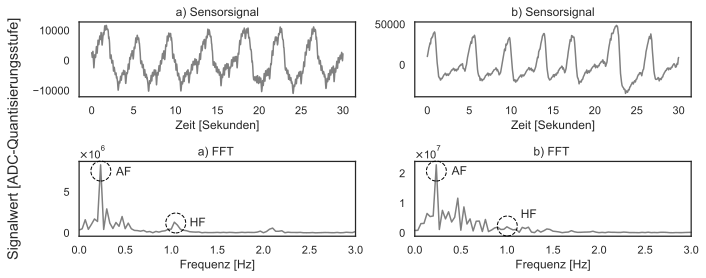

In [123]:
from matplotlib.patches import Circle
sns.set(rc={"figure.figsize": (10, 4)})
sns.set_style("white")
fig, ax = plt.subplots(2,2)
N = len(bp_filt[low_good+offset2:low_good+offset2+2575])
yf = rfft(bp_filt[low_good+offset2:low_good+offset2+2575])
xf = rfftfreq(N, 1 / fs_sm)
#hr = 60*xf[np.argmax((np.abs(yf)))]
ax[0,0].plot(np.linspace(0, 2575 / fs_sm, 2575),bp_filt[low_good+offset2:low_good+offset2+2575], color="grey")
ax[0,0].set_title("a) Sensorsignal")
ax[0,0].set_xlabel("Zeit [Sekunden]")
ax[1,0].plot(xf, np.abs(yf), color="grey")
ax[1,0].ticklabel_format(style="sci", axis="y", useMathText=True)
ax[1,0].set_title(f"a) FFT ")#(Peak: {xf[np.argmax((np.abs(yf)))]:.3f} Hz/{hr:.1f} bpm)")
ax[1,0].set_xlabel("Frequenz [Hz]")
ax[1,0].set_xlim(0,3)
move=1360000
N = len(bp_filt[low_good+move:low_good+move+2575])
yf = rfft(bp_filt[low_good+move:low_good+move+2575])
xf = rfftfreq(N, 1 / fs_sm)
#hr = 60*xf[np.argmax((np.abs(yf)))]
ax[0,1].plot(np.linspace(0, 2575 / fs_sm, 2575),bp_filt[low_good+move:low_good+move+2575], color="grey")
ax[0,1].set_xlabel("Zeit [Sekunden]")
ax[0,1].set_title("b) Sensorsignal")
ax[1,1].plot(xf, np.abs(yf), color="grey")
ax[1,1].ticklabel_format(axis="y", useMathText=True)
ax[1,1].set_title(f"b) FFT ")#(Peak: {xf[np.argmax((np.abs(yf)))]:.3f} Hz/{hr:.1f} bpm)")
ax[1,1].set_xlabel("Frequenz [Hz]")
ax[1,1].set_xlim(0,3)
fig.supylabel("Signalwert [ADC-Quantisierungsstufe]")
cir1 = Circle((101,107), 10, fill=False, ec="black", ls="--")
cir2 = Circle((176,55), 10, fill=False, ec="black", ls="--")
cir3 = Circle((437,107), 10, fill=False, ec="black", ls="--")
cir4 = Circle((508,52), 10, fill=False, ec="black", ls="--")
fig.artists.append(cir1)
fig.artists.append(cir2)
fig.artists.append(cir3)
fig.artists.append(cir4)
ax[1,0].text(0.4,7e6, s="AF")
ax[1,0].text(1.2,0.8e6, s="HF")
ax[1,1].text(0.4,1.95e7, s="AF")
ax[1,1].text(1.15,0.5e7, s="HF")
plt.tight_layout()
plt.show()

In [9]:
# Calculate Heartrates, HRV
print("Calculating Heart Rates + Heartrate Variability...")
# ignore warnings raised by heartpy
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    heart_rates, hrv, hr_timecodes, hr_fail_rate = sa.hr_hrv(resampled_hr_filt, (fs_sm * 4))
# remove outliers > +-5 sigma, converts to np.array
heart_rates = sa.reject_outliers(heart_rates, m=5)
# data for plot to visualize failed HR calc
hr_with_nans = np.copy(heart_rates)
hr_only_nans = np.zeros(len(heart_rates))
# interpolate to fill gaps, https://stackoverflow.com/a/6520696
nans_hr, x_hr = np.isnan(heart_rates), lambda z: z.nonzero()[0]
heart_rates[nans_hr] = np.round(np.interp(x_hr(nans_hr), x_hr(~nans_hr), heart_rates[~nans_hr]), 0)

Calculating Heart Rates + Heartrate Variability...


In [10]:
fft_hr = sa.hr_fft(resampled_hr_filt, (fs_sm * 4))
fft_hr = sa.reject_outliers(fft_hr, m=3)
fft_failed = np.count_nonzero(np.isnan(fft_hr))
fft_hr_fail_rate = fft_failed / len(fft_hr)
fft_hr_with_nans = np.copy(fft_hr)
fft_hr_only_nans = np.zeros(len(fft_hr))
# interpolate to fill gaps, https://stackoverflow.com/a/6520696
fft_nans_hr, fft_x_hr = np.isnan(fft_hr), lambda z: z.nonzero()[0]
fft_hr[fft_nans_hr] = np.round(np.interp(fft_x_hr(fft_nans_hr), fft_x_hr(~fft_nans_hr), fft_hr[~fft_nans_hr]), 0)

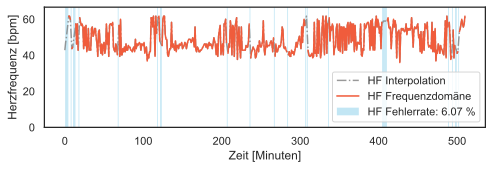

In [11]:
fft_hr_only_nans[fft_nans_hr] = 150
sns.set(rc={"figure.figsize": (7, 2.5)})
sns.set_style("white")
plt.plot(fft_hr, color="grey", alpha=0.8, label="HF Interpolation", linestyle="-.")
plt.plot(fft_hr_with_nans,color="#F05C3C",alpha=1,linewidth=1.5,label="HF Frequenzdomäne",)
plt.bar(hr_timecodes,fft_hr_only_nans,width=1,color="skyblue",edgecolor="none",alpha=0.5,label=f"HF Fehlerrate: {fft_hr_fail_rate * 100:.2f} %")
plt.ylim(top=max(fft_hr) + 5)
plt.ylabel("Herzfrequenz [bpm]")
plt.xlabel("Zeit [Minuten]")
plt.legend(loc="lower right")
#plt.grid(axis="x")
plt.tight_layout()
plt.show()

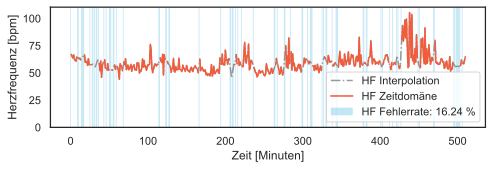

In [12]:
# plot all the HR calc stuff
# create array to mark the NaN values of HR-Calculation
hr_only_nans[nans_hr] = 150
sns.set(rc={"figure.figsize": (7, 2.5)})
sns.set_style("white")
plt.plot(heart_rates, color="grey", alpha=0.8, label="HF Interpolation", linestyle="-.")
plt.plot(hr_with_nans,color="#F05C3C",alpha=1,linewidth=1.5,label="HF Zeitdomäne",)
plt.bar(hr_timecodes,hr_only_nans,width=1,color="skyblue",edgecolor="none",alpha=0.5,label=f"HF Fehlerrate: {hr_fail_rate * 100:.2f} %")
plt.ylim(top=max(heart_rates) + 5)
plt.ylabel("Herzfrequenz [bpm]")
plt.xlabel("Zeit [Minuten]")
plt.legend(loc="lower right")
#plt.grid(axis="x")
plt.tight_layout()
plt.show()


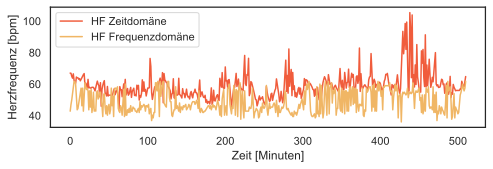

In [13]:
#plot comparison
sns.set(rc={"figure.figsize": (7, 2.5)})
sns.set_style("white")
plt.plot(heart_rates,color="#F05C3C",label="HF Zeitdomäne")
plt.plot(fft_hr, color="#f0b665", label="HF Frequenzdomäne")
plt.ylabel("Herzfrequenz [bpm]")
plt.xlabel("Zeit [Minuten]")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [14]:
# needs to be np array
hrv = np.array(hrv)
hrv_with_nans = np.copy(hrv)
hrv_only_nans = np.zeros(len(hrv))
# interpolate to fill gaps, https://stackoverflow.com/a/6520696
nans_hrv, x_hrv = np.isnan(hrv), lambda z: z.nonzero()[0]
hrv[nans_hrv] = np.round(np.interp(x_hrv(nans_hrv), x_hrv(~nans_hrv), hrv[~nans_hrv]), 0)

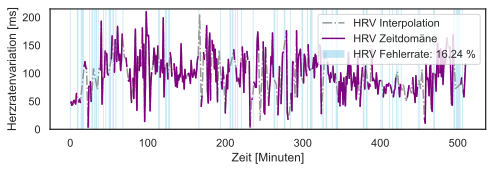

In [15]:
#plot hrv
hrv_only_nans[nans_hr] = 500
sns.set(rc={"figure.figsize": (7, 2.5)})
sns.set_style("white")
plt.plot(hrv, color="grey", alpha=0.8, label="HRV Interpolation", linestyle="-.")
plt.plot(hrv_with_nans,color="purple",alpha=1,linewidth=1.5,label="HRV Zeitdomäne",)
plt.bar(hr_timecodes,hrv_only_nans,width=1,color="skyblue",edgecolor="none",alpha=0.5,label=f"HRV Fehlerrate: {hr_fail_rate * 100:.2f} %")
plt.ylim(top=max(hrv) + 5)
plt.ylabel("Herzratenvariation [ms]")
plt.xlabel("Zeit [Minuten]")
plt.legend(loc="upper right")
#plt.grid(axis="x")
plt.tight_layout()
plt.show()


In [16]:
print("Calculating Respiratory Rates + Movement...")
resp_rates, movement, rr_timecodes = sa.rr_mvt(rr_filt, fs_sm)
# remove outliers > +-5 sigma, converts to np.array
resp_rates = sa.reject_outliers(resp_rates, m=5)
# calculate new failure rate
failed = np.count_nonzero(np.isnan(resp_rates))
rr_fail_rate = failed / len(resp_rates)
# data for plot to visualize failed HR calc
rr_with_nans = np.copy(resp_rates)
rr_only_nans = np.zeros(len(resp_rates))
# interpolate to fill gaps, https://stackoverflow.com/a/6520696
nans_rr, x_rr = np.isnan(resp_rates), lambda z: z.nonzero()[0]
resp_rates[nans_rr] = np.round(np.interp(x_rr(nans_rr), x_rr(~nans_rr), resp_rates[~nans_rr]), 0)
print("Respiratory Rates + Movement done!")

Calculating Respiratory Rates + Movement...
Respiratory Rates + Movement done!


In [17]:
fft_rr = sa.rr_fft(resampled_rr_filt, (fs_sm * 4))
fft_rr = sa.reject_outliers(fft_rr, m=5)
fft_failed = np.count_nonzero(np.isnan(fft_rr))
fft_rr_fail_rate = fft_failed / len(fft_rr)
fft_rr_with_nans = np.copy(fft_rr)
fft_rr_only_nans = np.zeros(len(fft_rr))
fft_nans_rr, fft_x_rr = np.isnan(fft_rr), lambda z: z.nonzero()[0]
fft_rr[fft_nans_rr] = np.round(np.interp(fft_x_rr(fft_nans_rr), fft_x_rr(~fft_nans_rr), fft_rr[~fft_nans_rr]), 0)

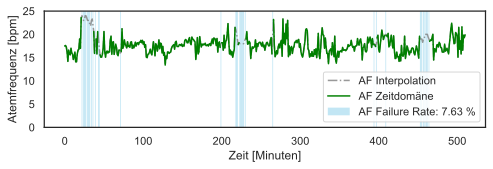

In [18]:
# create array to mark the NaN values of HR-Calculation
rr_only_nans[nans_rr] = 150
sns.set(rc={"figure.figsize": (7, 2.5)})
sns.set_style("white")
plt.plot(resp_rates, color="grey", alpha=0.8, label="AF Interpolation", linestyle="-.")
plt.plot(rr_with_nans,color="green",alpha=1,linewidth=1.5,label="AF Zeitdomäne")
plt.bar(rr_timecodes,rr_only_nans,width=1,color="skyblue",edgecolor="none",alpha=0.5,label=f"AF Failure Rate: {rr_fail_rate * 100:.2f} %",)
plt.ylim(top=max(resp_rates) + 1)
plt.ylabel("Atemfrequenz [bpm]")
plt.xlabel("Zeit [Minuten]")
plt.legend(loc="lower right")
#plt.grid(axis="x")
plt.tight_layout()
plt.show()

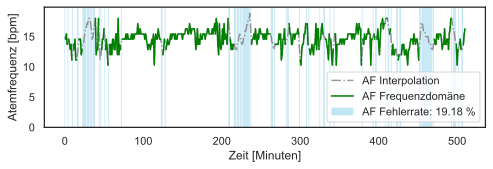

RR Fehlerrate: 19.18 %


In [19]:
# create array to mark the NaN values of HR-Calculation
fft_rr_only_nans[fft_nans_rr] = 150
sns.set(rc={"figure.figsize": (7, 2.5)})
sns.set_style("white")
plt.plot(fft_rr, color="grey", alpha=0.8, label="AF Interpolation", linestyle="-.")
plt.plot(fft_rr_with_nans,color="green",alpha=1,linewidth=1.5,label="AF Frequenzdomäne",)
plt.bar(rr_timecodes,fft_rr_only_nans,width=1,color="skyblue",edgecolor="none",alpha=0.5,label=f"AF Fehlerrate: {fft_rr_fail_rate * 100:.2f} %")
plt.ylim(top=max(fft_rr) + 1)
plt.ylabel("Atemfrequenz [bpm]")
plt.xlabel("Zeit [Minuten]")
plt.legend(loc="lower right")
#plt.grid(axis="x")
plt.tight_layout()
plt.show()
print(f"RR Fehlerrate: {fft_rr_fail_rate * 100:.2f} %")

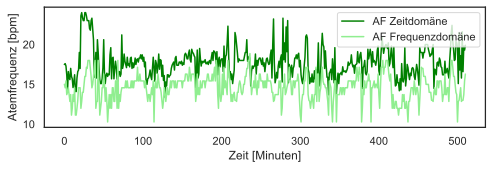

In [20]:
#plot comparison
sns.set(rc={"figure.figsize": (7, 2.5)})
sns.set_style("white")
plt.plot(resp_rates,color="green",label="AF Zeitdomäne")
plt.plot(fft_rr, color="lightgreen", label="AF Frequenzdomäne")
plt.ylabel("Atemfrequenz [bpm]")
plt.xlabel("Zeit [Minuten]")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

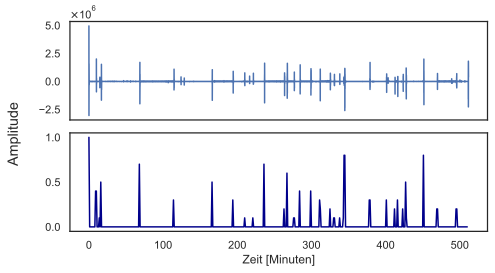

In [21]:
# Movement
sns.set(rc={"figure.figsize": (7, 4)})
sns.set_style("white")
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot((data["smoothed_ts"]-first)/60_000_000,bp_filt)
ax[0].ticklabel_format(axis="y", useMathText=True)
ax[1].plot(movement,color="darkblue")
fig.supylabel("Amplitude")
ax[1].set_yticks(ticks=[0,5,10],labels=[0.0,0.5,1.0])
ax[1].set_xlabel("Zeit [Minuten]")
plt.tight_layout()
plt.show()

In [22]:
# Determine Sleep Phases
print("Sleep Analysis...")
(sp_values,sp_stats,hr_avg_plot,rmssd_avg_plot,rr_avg_plot,mvt_avg_plot,hr_ref_plot,rmssd_ref_plot,rr_ref_plot,mvt_ref_plotv) = sa.sleep_phases(heart_rates, hrv, resp_rates, movement)
print("Sleep Analysis done!")
print(sp_stats)


Sleep Analysis...
Sleep Analysis done!
{'Dauer': '08:31 h', 'Tief': '01:56 h', 'Leicht': '04:18 h', 'REM': '02:09 h', 'Unterbrechungen': 2, 'Mittlere HF': '57 bpm', 'Mittlere AF': '17.6 bpm'}


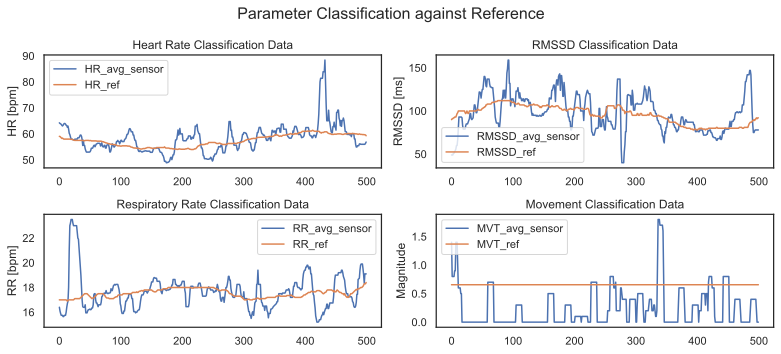

In [23]:
# plot the data of sleep phase calculation
plt.rcParams["figure.figsize"] = [11, 5]
plt.suptitle("Parameter Classification against Reference", fontsize=16)
plt.subplot(221, title="Heart Rate Classification Data", ylabel="HR [bpm]")
plt.plot(hr_avg_plot, label="HR_avg_sensor")
plt.plot(hr_ref_plot, label="HR_ref")
plt.legend()
plt.subplot(222, title="RMSSD Classification Data", ylabel="RMSSD [ms]")
plt.plot(rmssd_avg_plot, label="RMSSD_avg_sensor")
plt.plot(rmssd_ref_plot, label="RMSSD_ref")
plt.legend()
plt.subplot(223, title="Respiratory Rate Classification Data", ylabel="RR [bpm]")
plt.plot(rr_avg_plot, label="RR_avg_sensor")
plt.plot(rr_ref_plot, label="RR_ref")
plt.legend()
plt.subplot(224, title="Movement Classification Data", ylabel="Magnitude")
plt.plot(mvt_avg_plot, label="MVT_avg_sensor")
plt.plot(mvt_ref_plotv, label="MVT_ref")
plt.legend()
plt.tight_layout()
plt.show()